In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

%matplotlib inline

/Users/ik/.virtualenvs/rentprediction/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import scripts.helper as helper

### Load training and testing datasets from class websites

Training set contains sample of 12,000 homes posted on StreetEasy between May 2018 and July 2018 from StreetEasy.

In [3]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)

### Load datasets to test model for accuracy

In [4]:
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv',index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv')

### Load external datasets appended to training set to increase accuracy

* Complaint dataset: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i
 * Only used 2018 to correspond to time of rental listings
* 311 Service Requests: https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

In [5]:
nypd_complaints = pd.read_csv('datasets/2018_NYPD_Complaints.csv', index_col=0)
zip_incidents =  pd.read_csv('datasets/zip_incident_df.csv',index_col=0)

### Join external datasets onto training data using helper function

In [6]:
train_df = helper.merge_external_data(train_df, nypd_complaints, zip_incidents)
test_df = helper.merge_external_data(test_df, nypd_complaints, zip_incidents)
submit1_df = helper.merge_external_data(submit1_df, nypd_complaints, zip_incidents)
submit2_df = helper.merge_external_data(submit2_df, nypd_complaints, zip_incidents)

### List all columns, shape, and show sample of training data with appended features

In [7]:
train_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line', 'precinct',
       'petit_larceny', 'harrassment_2', 'assault_3', 'criminal_mischief',
       'grand_larceny', 'public_order', 'felony_assault', 'dangerous_drugs',
       'penal_law', 'robbery', 'burglary', 'misdemenor', 'felony', 'violation',
       'Number of Incidents'],
      dtype='object')

In [8]:
train_df.shape

(12000, 54)

In [9]:
train_df.sample(5).transpose()

,3000,7935,9004,8579,7547
addr_unit,#1A,UNIT-29C,#6AN,#4E,#3L
building_id,1396831,51214,18714649,1299817,392389
bedrooms,0,1,2,3,2
bathrooms,1.000000,1.000000,1.000000,2.000000,1.000000
size_sqft,570.000000,705.000000,500.000000,1000.000000,788.000000
created_at,2018-07-11 09:43:39,2018-05-29 18:04:57,2018-05-10 11:25:53,2018-06-04 15:22:56,2018-05-14 16:58:18
addr_street,110-35 72 DRIVE,260 WEST 54 STREET,210 THOMPSON STREET,26-38 21ST STREET,1356 WILLOUGHBY AVENUE
addr_city,Forest Hills,New York,New York,Astoria,Brooklyn
addr_zip,11375,10019,10012,11102,11237
addr_lat,40.720354,40.764301,40.728699,40.772202,40.706312


### Here is a scatter plot that shows the correlation between the size of a listing and the rental price
As one might guess, the larger an apartment, the more that it probably costs.
Note that there are some outliers here towards the bottom right of the plot which are probably incorrectly listed values in the data. Removing some of these outliers may improve the accuracy of our model.

Text(0, 0.5, 'Rent ($)')

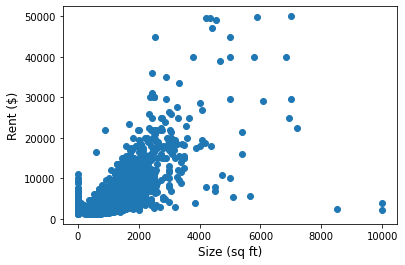

In [10]:
plt.scatter(train_df['size_sqft'],train_df['rent'])
plt.xlabel('Size (sq ft)', fontsize=12)
plt.ylabel('Rent ($)', fontsize=12)

### Build training data (using relevant features)
Avoided features with strings as the type i.e. 'addr_city', 'neighborhood', 'borough'
Can try converting them to binary to find out how important they are

In [11]:
# extract usable features
features = ['bedrooms', 'bathrooms', 'size_sqft', 'addr_zip', 'bin', 'bbl',
                    'floor_count', 'has_doorman', 'has_elevator',
                    'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets',
                    'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool',
                    'precinct', 'petit_larceny', 'harrassment_2', 'assault_3', 'criminal_mischief',
                    'grand_larceny', 'public_order', 'felony_assault', 'dangerous_drugs', 'penal_law',
                    'robbery', 'burglary', 'misdemenor', 'felony', 'violation', 'has_garden', 
                    'has_childrens_playroom', 'Number of Incidents', 'no_fee', 'rent']


# More selective features (comment out to test every feature)
# features = ['size_sqft', 'bbl', 'bathrooms', 'bedrooms', 'rent']

# drop rows with missing values
train_features = train_df[features].dropna()

# construct target vector
train_target = train_features['rent']
train_features = train_features.drop(labels='rent', axis=1)
print(train_features.isna().sum().sum())

# setup test data for predicting and measuring
test_features = test_df[features]
test_target = test_features['rent']
test_features = test_features.drop(labels='rent', axis=1)

0


It makes sense for the submission datasets to have at least 2000 missing values because we are supposed to predict the rent with our model. The extra missing value in 'training' and 'submission 2' are contained in the bin column.

### Filling in missing bins with preselected value (1000000)

In [12]:
submit2_features = submit2_df[features].drop(labels='rent', axis=1)
print('Before filling in missing values: ', submit2_features.isnull().sum().sum())

submit2_features['bin'].fillna(1000000.0, inplace = True)
print('After filling in missing values: ', submit2_features.isnull().sum().sum())

Before filling in missing values:  2
After filling in missing values:  0


In [13]:
# check for missing values in training, testing, and submission dataframes
print('Training NaNs:', train_features.isna().sum().sum())
print('Test NaNs:', test_df[features].isna().sum().sum())
print('Submission 2 NaNs:', submit2_features.isna().sum().sum())

Training NaNs: 0
Test NaNs: 0
Submission 2 NaNs: 0


### Plotting BIN against BBL 
**BIN**: building identification number which is a 7-digit numerical identifier unique to each building in the City of New York. The first digit is the borough code which explains why the data shows like a step function.

**BBL**: Borough, Block and Lot Number which identifies each unit of real estate in NYC. It consists of three numbers, separated by slashes: the borough, which is 1 digit; the block number, which is up to 5 digits; and the lot number, which is up to 4 digits.

Text(0, 0.5, 'BBL')

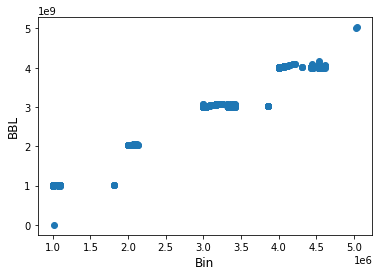

In [14]:
plt.scatter(test_df['bin'],test_df['bbl'])
plt.xlabel('Bin', fontsize=12)
plt.ylabel('BBL', fontsize=12)

In [15]:
#zip codes missing from the join function will go back and add these.
print(test_features.loc[test_features.precinct.isna(), 'addr_zip'])
print(submit1_df.loc[submit1_df.precinct.isna(), 'addr_zip'])
print(submit2_df.loc[submit2_df.precinct.isna(), 'addr_zip'])

Series([], Name: addr_zip, dtype: int64)
Series([], Name: addr_zip, dtype: int64)
Series([], Name: addr_zip, dtype: int64)


### Initializing multiple models to determine best for accuracy

In [16]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()

### Train and predict using each estimator and print MSE, std dev & mean of 5-fold cross validation on training set

In [17]:
names = ['\nLinear Regression', '\nDecision Tree Regressor', '\nGradient Boosting Regressor', '\nRandom Forest Regressor']
estimators = [lr, dt, gb, rf]

for i in range(len(names)):
    print(names[i])
    helper.getResults(estimators[i], train_features, train_target, test_features, test_target)


Linear Regression
Mean Squared Error:  3180974.0747734844
CV Results (Std Dev):  679826.9534078061
CV Results (Mean):  -3074207.5331912735

Decision Tree Regressor
Mean Squared Error:  2487152.096017361
CV Results (Std Dev):  617534.3447445956
CV Results (Mean):  -2114208.785424029

Gradient Boosting Regressor
Mean Squared Error:  1754539.6250079372
CV Results (Std Dev):  256851.84385502982
CV Results (Mean):  -1178863.3506404876

Random Forest Regressor
Mean Squared Error:  1656715.2450035047
CV Results (Std Dev):  241502.78286409398
CV Results (Mean):  -1168838.2846468263


#### GradientBoostingRegressor or RandomForestRegressor seems to give us the best score so far, further testing with hyperparameters is needed

### Print feature importances (from least important to most) for each estimator
Importances for lr are in magnitude while others are in percentage

Features are currently unscaled.

In [18]:
for i in range(len(names)):
    print(names[i])
    helper.getSortedImportances(estimators[i], features)


Linear Regression

Feature Importances
has_dishwasher -201.45612285523393
no_fee -184.7079288498617
has_garage -177.36064086541134
violation -7.46239943839439
criminal_mischief -4.007467438298224
floor_count -3.4279666466341343
dangerous_drugs -3.2369466381905685
public_order -2.708469375019197
petit_larceny -2.6198168253556986
felony_assault -2.282407057552217
assault_3 -1.9701945904628921
precinct -0.5890082668763902
addr_zip -0.4513327576340677
grand_larceny -0.09614473238464599
Number of Incidents -0.0320363069429247
bbl -4.5001232598653393e-07
bin 0.00016881656951438226
felony 0.46377802322051964
robbery 0.80267923896172
burglary 1.5190611497501332
size_sqft 2.3173222018094304
misdemenor 2.8851979547259767
penal_law 4.310846166281551
harrassment_2 6.175465776098679
has_garden 41.90215611578609
has_doorman 73.55686732569713
has_childrens_playroom 107.32829057011273
has_roofdeck 188.183410605416
allows_pets 203.2250443836145
has_concierge 206.3366651801876
has_pool 218.434106133817

### Tuning individual hyperparameters for decision tree regressor 

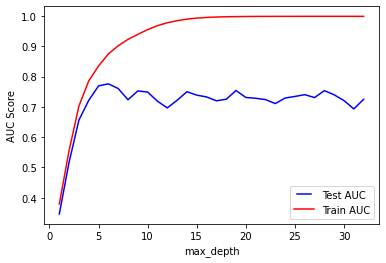

{'best_param': {'max_depth': 6}, 'best_score': 0.7758130062518085}


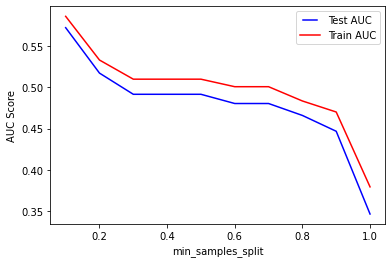

{'best_param': {'min_samples_split': 0.1}, 'best_score': 0.5724664746971202}


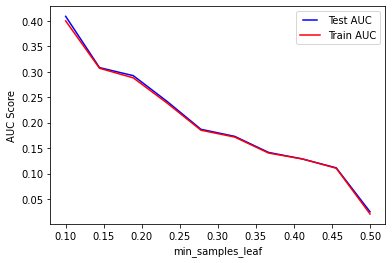

{'best_param': {'min_samples_leaf': 0.1}, 'best_score': 0.40932686793006995}


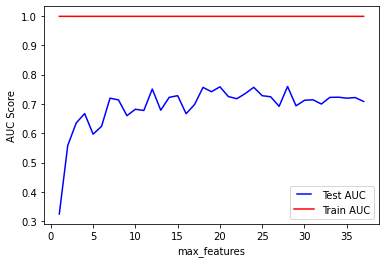

{'best_param': {'max_features': 28}, 'best_score': 0.759157735520526}


In [19]:
param_grids = []

# Hyperparameter 1: max_depth -> indicates depth of tree; 
# Testing range of 1 to 32
max_depth_values = np.arange(1, 33)
param_grids.append({'max_depth': max_depth_values})

# Hyperparameter 2: min_samples_split <- minimum number of samples required to split a node
# Testing range from 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
param_grids.append({'min_samples_split': min_samples_split})

# Hyperparameter 3: min_samples_leaf <- minimum number of samples required at each leaf node
# Testing range from 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint=True)
param_grids.append({'min_samples_leaf': min_samples_leaf})

# Hyperparameter 4: max_features <- max number of features to test
# Testing range from 1 to 1 less than the number of features in the df
max_features = list(range(1,train_features.shape[1]))
param_grids.append({'max_features': max_features})

for hyperparameter in param_grids:
    helper.testHyperparameter(hyperparameter, train_features, train_target)

### Testing all 4 hyperparameters together to find the best combination

In [20]:
param_grid = {
              "min_samples_split": [10, 20, 40, 80, 160],
              "max_depth": [2, 6, 8, 10, 15, 20, 30, 40, 50],
              "min_samples_leaf": [20, 40, 100, 200, 400],
              "max_leaf_nodes": [5, 20, 100, 200, 500]
              }

dtr = DecisionTreeRegressor()
dtr_cv = RandomizedSearchCV(dtr, param_grid, cv=5, n_iter = 1000, n_jobs=-1)
dtr_cv.fit(train_features, train_target)
print(dtr_cv.best_params_)
print(dtr_cv.best_score_)
print(dtr_cv.best_estimator_)

{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_leaf_nodes': 500, 'max_depth': 15}
0.7725453663576703
DecisionTreeRegressor(max_depth=15, max_leaf_nodes=500, min_samples_leaf=20,
                      min_samples_split=10)


### Results of predicting rent on test set using optimized decision tree

In [21]:
optimized_dt = dtr_cv.best_estimator_
test_pred = optimized_dt.predict(test_features)
cv_results = cross_val_score(optimized_dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

DecisionTreeRegressor
Mean Squared Error:  2508147.9750483544
CV Results:  [-2071613.93099836 -1979239.78232072 -2353279.84495234 -1512536.82748468
 -1498198.9586541 ]
Mean CV Results:  -1882973.8688820384


### Test code to see parameters of RandomForestRegressor

In [22]:
rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Setting up hyperparameters for random forest training

In [23]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16, 32],
 'min_samples_split': [2, 5, 10, 20, 50],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


### Random Search Training using 5 folds
Note that this training takes at least 10 minutes on a MBP 2020.

In [24]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                              cv = 5, random_state = 42, n_jobs = -1)

rf_random.fit(train_features, train_target)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16,
                                                             32],
                                        'min_samples_split': [2, 5, 10, 20, 50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42)

In [25]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

### Now testing optimized random forest and printing results

In [26]:
optimized_rf =  rf_random.best_estimator_
test_pred = optimized_rf.predict(test_features)
cv_results = cross_val_score(optimized_rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

Mean Squared Error:  1586317.6677488303
CV Results:  [-1515634.0809642   -856641.34880255 -1332940.63733162 -1104520.17186467
  -569939.25852185]
Mean CV Results:  -1075935.0994969807


#### Mean Squared Error slightly decreases.

In [27]:
test_pred

array([ 2581.231     ,  2115.0815    ,  2933.0955    , ...,
       14966.431     ,  3594.32      ,  2835.44166667])

In [28]:
test_rental_id = test_df.iloc[:,0]
print(test_rental_id)

0           #1B
1           #C4
2       #GARDEN
3           #2C
4            #9
         ...   
1995        #4H
1996       #11K
1997       #44A
1998       #15M
1999         #3
Name: addr_unit, Length: 2000, dtype: object


In [29]:
# checking for any missing values in test3.csv
submit2_features.isnull().sum().sum()

0

In [30]:
submit2_features[submit2_features['bin'].isnull()]

,bedrooms,bathrooms,size_sqft,addr_zip,bin,bbl,floor_count,has_doorman,has_elevator,has_fireplace,...,penal_law,robbery,burglary,misdemenor,felony,violation,has_garden,has_childrens_playroom,Number of Incidents,no_fee


### Score of optimized RandomForestRegressor

In [31]:
print(optimized_rf.score(train_features, train_target))

0.9982678928817742


### Create submission file for test2.csv (Commented out so the .csv doesn't get overwritten)

In [32]:
#submit1_df['predictions'] = optimized_rf.predict(submit1_features)
#submit1_df['predictions'].to_csv('test2_submission.csv', header=True)

### Checking feature importance for optimized random forest

In [33]:
helper.getSortedImportances(optimized_rf, features)


Feature Importances
has_garage 0.21533041363453528
has_childrens_playroom 0.37251453048823296
has_fireplace 0.3789807657723585
has_pool 0.3838676309700687
felony 0.38977221990527616
violation 0.39171188707543003
allows_pets 0.4203396523674855
public_order 0.4231835257052865
harrassment_2 0.4365809812373733
misdemenor 0.4391827265023041
burglary 0.44263515761670535
assault_3 0.521252287286668
dangerous_drugs 0.5837657386867622
has_roofdeck 0.5955063951093194
is_furnished 0.6128651080079618
petit_larceny 0.6347341903296588
robbery 0.6770552218628956
has_garden 0.6829348194696152
has_concierge 0.709826566497936
has_elevator 0.7201213878638644
has_gym 0.7317171026956647
has_doorman 0.7444095630821111
felony_assault 0.7505653270032532
has_dishwasher 0.8842519764552328
criminal_mischief 0.885558311126352
no_fee 1.0129609782538538
Number of Incidents 1.3978557853999287
grand_larceny 1.41188704677046
penal_law 1.6553284684070948
floor_count 2.5117456908884597
addr_zip 3.1219921771479573
preci

In [34]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# not too important to care about. just wanted to see parameters inside
from pprint import pprint

pprint(gb.get_params())

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


### Testing generic gradient boosting regressor again

In [35]:
gb.fit(train_features, train_target)
test_pred = gb.predict(test_features)
cv_results = cross_val_score(gb, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

Mean Squared Error:  1754236.671526169
CV Results:  [-1320330.846369   -1132020.28829302 -1486759.85622686 -1228639.69550397
  -721595.83625589]
Mean CV Results:  -1177869.3045297486


### Using the R-squared value allows us to see how much of the variance in the data our model is explains.

In [36]:
print("R-squared for Train: %.2f" %gb.score(train_features, train_target))
print("R-squared for Test: %.2f" %gb.score(test_features, test_target))

R-squared for Train: 0.91
R-squared for Test: 0.76


### Setting up hyperparameters

In [37]:
# Number of trees to be modeled 
n_estimators = [100, 200, 300, 400, 500]
    
# Number of features to consider when searching for a best split
max_features = [1.0, 0.5, 0.3, 0.1, 0.01, 0.001]

# Represents the impact of each tree 
learning_rate = [0.1, 0.05, 0.02, 0.01]
    
# Maximum number of levels in tree
max_depth = [2, 4, 6, 8, 10]
    
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 5, 7, 9, 15, 20]
    
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'learning_rate': [0.1, 0.05, 0.02, 0.01],
 'max_depth': [2, 4, 6, 8, 10],
 'max_features': [1.0, 0.5, 0.3, 0.1, 0.01, 0.001],
 'min_samples_leaf': [3, 5, 7, 9, 15, 20],
 'n_estimators': [100, 200, 300, 400, 500]}


### Random Search Training for Gradient Boosting 

In [38]:
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 50,
                              cv = 5, random_state = 42, n_jobs = -1)

gb_random.fit(train_features, train_target)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.02,
                                                          0.01],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': [1.0, 0.5, 0.3, 0.1,
                                                         0.01, 0.001],
                                        'min_samples_leaf': [3, 5, 7, 9, 15,
                                                             20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42)

In [39]:
gb_random.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 9,
 'max_features': 0.3,
 'max_depth': 6,
 'learning_rate': 0.1}

### Training a hypertuned GradientBoostedRegressor

In [40]:
optimized_gb =  gb_random.best_estimator_
test_pred = optimized_gb.predict(test_features)
cv_results = cross_val_score(optimized_gb, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

Mean Squared Error:  1535899.150927694
CV Results:  [-1134631.78462521  -839270.18017644 -1333019.38860664  -944182.71242079
  -652001.99726643]
Mean CV Results:  -980621.2126191042


### Testing each estimator for training and testing R^2 values

In [41]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
optimized_dt = dtr_cv.best_estimator_
optimized_gb =  gb_random.best_estimator_

estimators = [lr, dt, rf, gb, optimized_dt, optimized_gb]

train_r2 = []
test_r2 = []

def getRSquared(estimator):
    estimator.fit(train_features, train_target)
    test_pred = estimator.predict(test_features)
    train_cv_results = cross_val_score(estimator, train_features, train_target, cv=5, scoring = 'r2')
    test_cv_results = cross_val_score(estimator, test_features, test_pred, cv=5, scoring = 'r2')
    train_r2.append(np.mean(train_cv_results))
    test_r2.append(np.mean(test_cv_results))

In [42]:
for estimator in estimators:
    getRSquared(estimator)

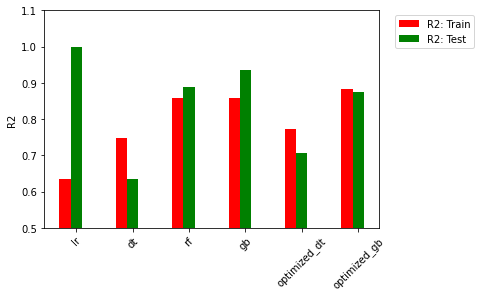

In [43]:
n = 6
ind = np.arange(n)  # the x locations for the groups
width = 0.2       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

train_rect = ax.bar(ind, train_r2, width, color='r')
test_rect = ax.bar(ind+width, test_r2, width, color='g')

ax.set_ylabel('R2')
ax.set_xticks(ind+width)
ax.set_xticklabels( ['lr', 'dt', 'rf', 'gb', 'optimized_dt', 'optimized_gb'], rotation=45 )
ax.legend( (train_rect[0], test_rect[0]), ('R2: Train', 'R2: Test'), loc=1, bbox_to_anchor=(0.5, 0.5, 0.8, 0.5) )
plt.ylim((0.5,1.1))

plt.show()

### Create submission file for test3.csv (Commented out so the .csv doesn't get overwritten)

In [44]:
# submit2_df['predictions'] = optimized_gb.predict(submit2_features)
# submit2_df[['rental_id','predictions']].to_csv('test3_submission.csv', header=True, index=False)

In [45]:
helper.getSortedImportances(optimized_gb)

TypeError: getSortedImportances() missing 1 required positional argument: 'features_list'